# Severity prediction of traffic accident in the City of Seattle 

This project aimed at predicting collision severity based on a dataset hosted by the City of Seattle. In particular, the collisions with only property damage are labeled as less severe accidents; the ones involving injuries are deemed as severe. The dataset consists of features such as environmental conditions (<em>e.g.</em>, weather, road condition, and lighting condition), time of the accident, location information (<em>e.g.</em>, type of road), as well as the number of people and vehicles involved. Some of these factors, such as the number of cyclists in the recorded accidents, tend to be obvious features in predicting the severity of the collision, whereas some may be inevident (<em>e.g.</em>, particular road region) but bearing important insights into mitigating the severity of traffic accidents for the city.  

---
## Data
* Categorical features

## Model

## Insights

### Load libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from matplotlib import pyplot as plt
import seaborn as sns

### Read and explore the dataset

In [240]:
df = pd.read_csv('Data-Collisions.csv', low_memory=False, parse_dates=["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

print(df.shape)
df.head()

(194673, 40)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,NaN,NaN,NaN,10,Entering at angle,0,0,N,3,2013
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,12,2006
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,11,2004
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,NaN,NaN,NaN,23,From same direction - all others,0,0,N,3,2013
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,1,2004


In [230]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

1    70.109877
2    29.890123
Name: SEVERITYCODE, dtype: float64


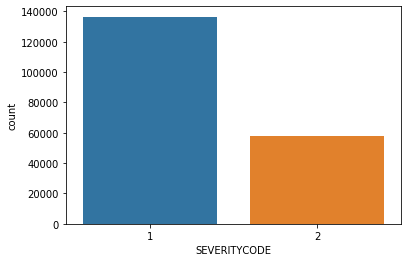

In [245]:
sns.countplot(df["SEVERITYCODE"])

print(df["SEVERITYCODE"].value_counts(normalize=True)*100)


In [251]:
# data type and cardinality for each feature
col_names = []
col_cardinality = []

for feature in df.columns:
    col_names.append(feature)
    cardinality = len(df[feature].unique())
    col_cardinality.append(cardinality)
    
pd.DataFrame([col_cardinality], columns=col_names)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,23564,23840,194673,194673,194673,194670,2,4,7615,...,2,114933,2,64,63,1955,2198,2,12,17


In [244]:
# distribution of severity among cardinality for each feature
feature = 'UNDERINFL'
df[[feature, "SEVERITYCODE"]].groupby([feature, "SEVERITYCODE"]).size()

# df.groupby(by=feature).size()  #if only interested in how feature is distributed

UNDERINFL  SEVERITYCODE
0          1               57693
           2               22701
1          1                2372
           2                1623
N          1               69378
           2               30896
Y          1                3187
           2                1939
dtype: int64

In [241]:
df['PEDROWNOTGRNT'].describe()

count     4667
unique       1
top          Y
freq      4667
Name: PEDROWNOTGRNT, dtype: object

#### Locations

(-122.39972081136344,
 -122.27004288863661,
 47.5025454816358,
 47.731724108364205)

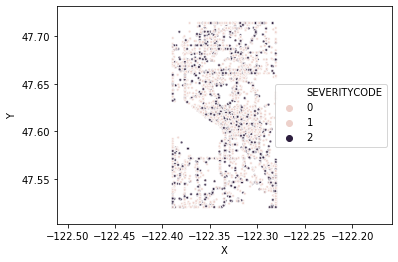

In [148]:
# plot the X/Y coordinates as a scatterplot where each dot is color-coded by the severity code.
# we randomly sample N (e.g. N=5000) to prevent from cluttering.
# X/Y values are clamped so that they are not affected by outliers

indices = np.arange(df.shape[0])
np.random.shuffle(indices)

g = sns.scatterplot(data=df.loc[indices[:5000], :], x='X', y='Y', hue='SEVERITYCODE', alpha=.8, s=8)

# df['Y'].quantile([.05, .95])  # the range of X,Y coordinates for location
g.set(xlim=df['X'].quantile([.05, .95]), ylim=df['Y'].quantile([.05, .95]))
plt.axis('equal')

In [124]:
# we can also plot the likelihood of severity on one axis at a time, at a coarser granularity

def binify_values(s, clamp_alpha=.05, bins=50):
    low, hi = s.quantile([clamp_alpha, 1.0 - clamp_alpha])
    s[s < low] = low
    s[s > hi] = hi
    
    return pd.cut(s, bins)

In [141]:
def compute_severity_ratio(g):
    severity_counts = g.groupby('SEVERITYCODE').size()
    ratio = severity_counts.iloc[0] / severity_counts.iloc[1]
    return ratio


def severity_location_distribution(df, loc, nbin):
    
    # dataframe with binned loc and severity within that range
    df_loc = pd.DataFrame({loc: binify_values(df[loc], bins=nbin), 'SEVERITYCODE': df['SEVERITYCODE']})
    
    # count each severity level
    loc_by_severity_counts = df_loc.groupby([loc, 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
    
    # visualize
    sns.barplot(data=loc_by_severity_counts, x=loc, y='count', hue='SEVERITYCODE')
#     df_loc.groupby(loc).apply(compute_severity_ratio).plot()


/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/i

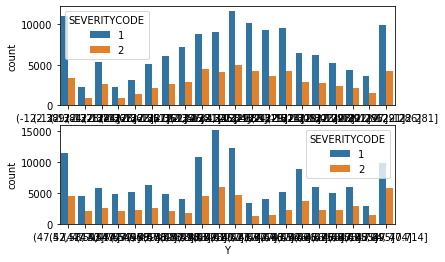

In [143]:
plt.subplot(2, 1, 1)
severity_location_distribution(df, 'X', nbin=20)

plt.subplot(2, 1, 2)
severity_location_distribution(df, 'Y', nbin=20)


#### Time of the day
For example, distribution of collision severity by month & time of the day

In [233]:
df['INCDTTM'] #'INCDTTM', 'INCDATE'

0           3/27/2013 2:54:00 PM
1          12/20/2006 6:55:00 PM
2         11/18/2004 10:20:00 AM
3           3/29/2013 9:26:00 AM
4           1/28/2004 8:04:00 AM
                   ...          
194668     11/12/2018 8:12:00 AM
194669     12/18/2018 9:14:00 AM
194670      1/19/2019 9:25:00 AM
194671      1/15/2019 4:48:00 PM
194672     11/30/2018 3:45:00 PM
Name: INCDTTM, Length: 194673, dtype: object

In [239]:
# df['INCDATE']



0          3
1         12
2         11
3          3
4          1
          ..
194668    11
194669    12
194670     1
194671     1
194672    11
Name: INCDATE, Length: 194673, dtype: int64

### Data preprocess 

#### Data clean up
(fillna & missing data, combine same meaning labels)

In [ ]:


# e.g., UNDERINFL


#### One hot encoding of categorical features

In [204]:
def categ_to_one_hot(df, feature='ROADCOND'):
    enc = preprocessing.OneHotEncoder()
    # fill in None, to reshape to 2D (column)
    col = df[feature].fillna("").values.reshape(-1, 1)
    # one hot encode
    one_hot_encoded = enc.fit_transform(col).toarray()
    
    # to a data frame
    df_cols = {}
    for col_index, cat in enumerate(enc.categories_[0]):
        df_cols[feature + '_' + cat] = one_hot_encoded[:, col_index]

    return pd.DataFrame(df_cols)

In [226]:
df_addrtype = categ_to_one_hot(df, feature='ADDRTYPE')
df_collisiontype = categ_to_one_hot(df, feature='COLLISIONTYPE')
df_junctiontype = categ_to_one_hot(df, feature='JUNCTIONTYPE')

df_weather = categ_to_one_hot(df, feature='WEATHER')
df_roadcond = categ_to_one_hot(df, feature='ROADCOND')
df_ligthcond = categ_to_one_hot(df, feature='LIGHTCOND')

['' 'Alley' 'Block' 'Intersection']
['' 'Angles' 'Cycles' 'Head On' 'Left Turn' 'Other' 'Parked Car'
 'Pedestrian' 'Rear Ended' 'Right Turn' 'Sideswipe']
['' 'At Intersection (but not related to intersection)'
 'At Intersection (intersection related)' 'Driveway Junction'
 'Mid-Block (but intersection related)'
 'Mid-Block (not related to intersection)' 'Ramp Junction' 'Unknown']
['' 'Blowing Sand/Dirt' 'Clear' 'Fog/Smog/Smoke' 'Other' 'Overcast'
 'Partly Cloudy' 'Raining' 'Severe Crosswind' 'Sleet/Hail/Freezing Rain'
 'Snowing' 'Unknown']
['' 'Dry' 'Ice' 'Oil' 'Other' 'Sand/Mud/Dirt' 'Snow/Slush'
 'Standing Water' 'Unknown' 'Wet']
['' 'Dark - No Street Lights' 'Dark - Street Lights Off'
 'Dark - Street Lights On' 'Dark - Unknown Lighting' 'Dawn' 'Daylight'
 'Dusk' 'Other' 'Unknown']


### Model

In [227]:
df_one_hot = pd.concat([df_addrtype, df_collisiontype, df_junctiontype, 
                        df_weather, df_roadcond, df_ligthcond, 
                        df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT','VEHCOUNT']]], axis=1)
df_one_hot

,ADDRTYPE_,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,COLLISIONTYPE_,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,...,LIGHTCOND_Dark - Unknown Lighting,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown,PERSONCOUNT,PEDCYLCOUNT,PEDCOUNT,VEHCOUNT
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0,2
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,2
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4,0,0,3
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3,0,0,3
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3,0,0,2
194669,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0,2
194670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3,0,0,2
194671,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2,1,0,1


In [228]:
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, df_one_hot, df['SEVERITYCODE'], cv=10)

array([0.74321964, 0.74357921, 0.75256832, 0.75697334, 0.7590281 ,
       0.75348025, 0.75003853, 0.74921662, 0.74526121, 0.75147686])